In [292]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [293]:
row_img = cv2.imread("cam1.jpg")
img = cv2.cvtColor(row_img, cv2.COLOR_BGR2RGB)

# Showing image

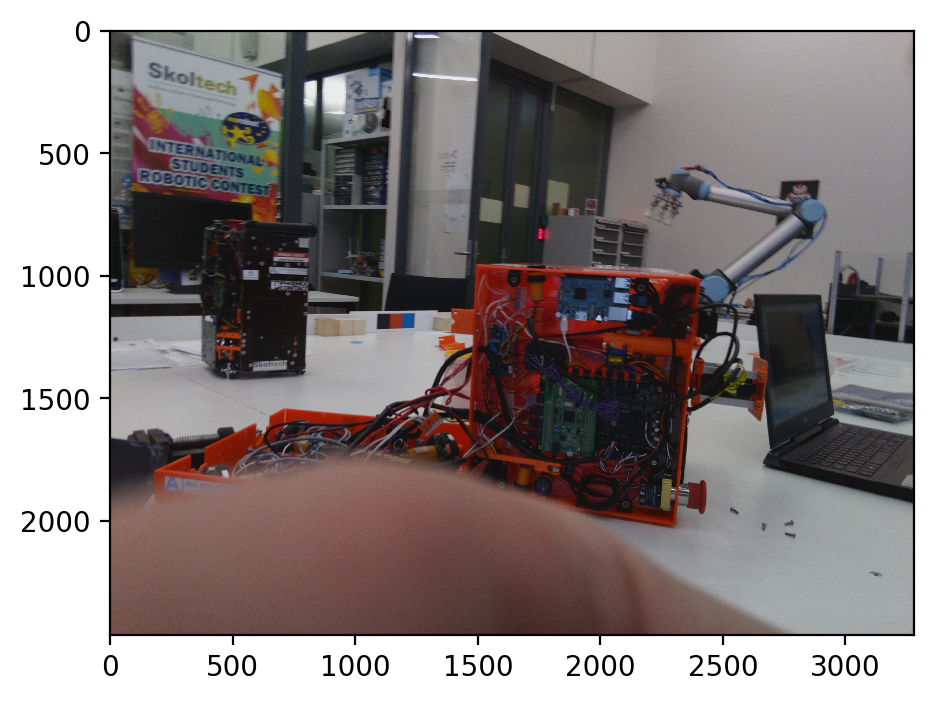

In [294]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.imshow(img);
# ax.set_ylim(1680, 1600)
# ax.set_xlim(1340, 1520)

# Projection transformation

In [295]:
def eulerAnglesToRotationMatrix(theta):
    R_x = np.array([[1, 0, 0], [0, np.cos(theta[0]), -np.sin(theta[0])],
                    [0, np.sin(theta[0]),
                     np.cos(theta[0])]])
    R_y = np.array([[np.cos(theta[1]), 0,
                     np.sin(theta[1])], [0, 1, 0],
                    [-np.sin(theta[1]), 0,
                     np.cos(theta[1])]])
    R_z = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                    [np.sin(theta[2]), np.cos(theta[2]), 0], [0, 0, 1]])
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R


def get_camera_matrix(f, pixel_size, img_size, rotation_matrix,
                      camera_position):
    H = np.array([[f / pixel_size, 0, img_size[0] / 2],
                  [0, f / pixel_size, img_size[1] / 2], [0, 0, 1]])
    t = -rotation_matrix.dot(camera_position)
    M = np.concatenate((rotation_matrix, t), axis=1)
    return H.dot(M)

In [296]:
rotation_matrix = eulerAnglesToRotationMatrix((np.pi / 2, np.pi / 4, 0.1))
camera_matrix = get_camera_matrix(
    f=3.04,
    pixel_size=1.12e-3,
    img_size=(3280, 2464),
    rotation_matrix=rotation_matrix,
    camera_position=np.array([[2000], [0], [300]]))
plane_matrix = np.array([[0, 0, 0], [1, 0, 1500 - 3 * 90], [0, -1, 70 + 400],
                         [0, 0, 1]])
tr_matrix = np.linalg.inv(camera_matrix.dot(plane_matrix))

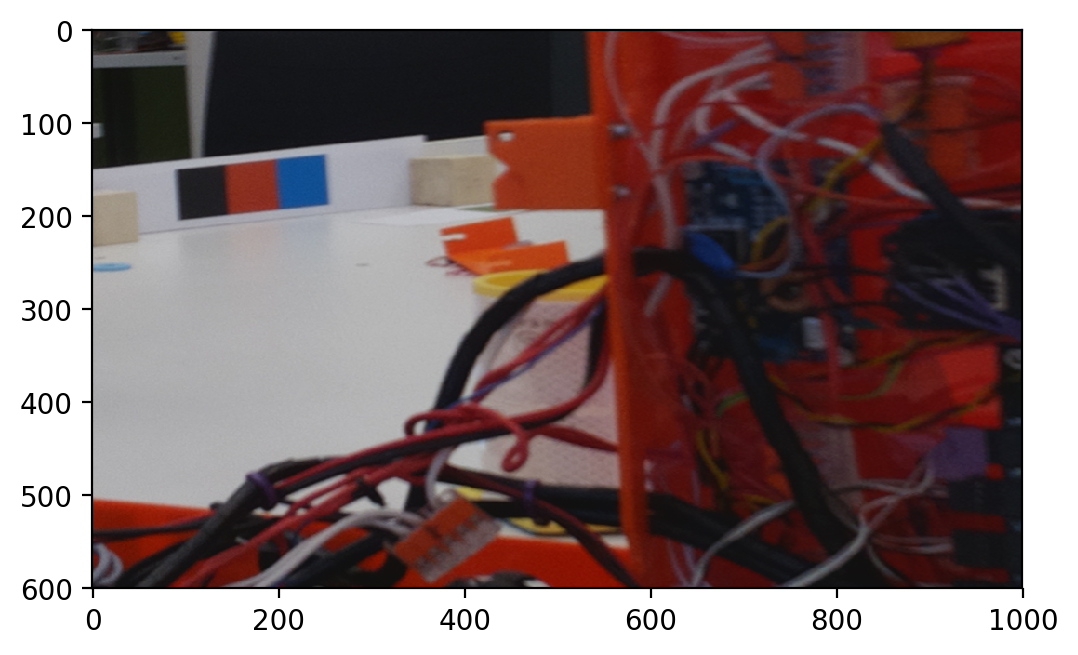

In [297]:
tr_img = cv2.warpPerspective(img, tr_matrix, (1000, 600))
fig, ax = plt.subplots(1, 1, dpi=200)
ax.imshow(tr_img)

# Rough image

In [298]:
def averege_colors(img):
    N = img.shape[0] * img.shape[1]
    return np.sum(np.sum(img, axis=0), axis=0) // N

In [299]:
step = 30
n_y = tr_img.shape[0] // step
n_x = tr_img.shape[1] // step
avg_colors = np.zeros((n_x, n_y, 3), dtype=np.uint8)
rough_img = np.zeros((n_y * step, n_x * step, 3), dtype=np.uint8)
for i in range(n_y):
    for j in range(n_x):
        color = averege_colors(
            tr_img[i * step:i * step + step, j * step:j * step + step])
        avg_colors[j, i] = color
        rough_img[i * step:i * step + step, j * step:
                  j * step + step] = np.tensordot(
                      np.ones((step, step), dtype=np.int8), color, axes=0)

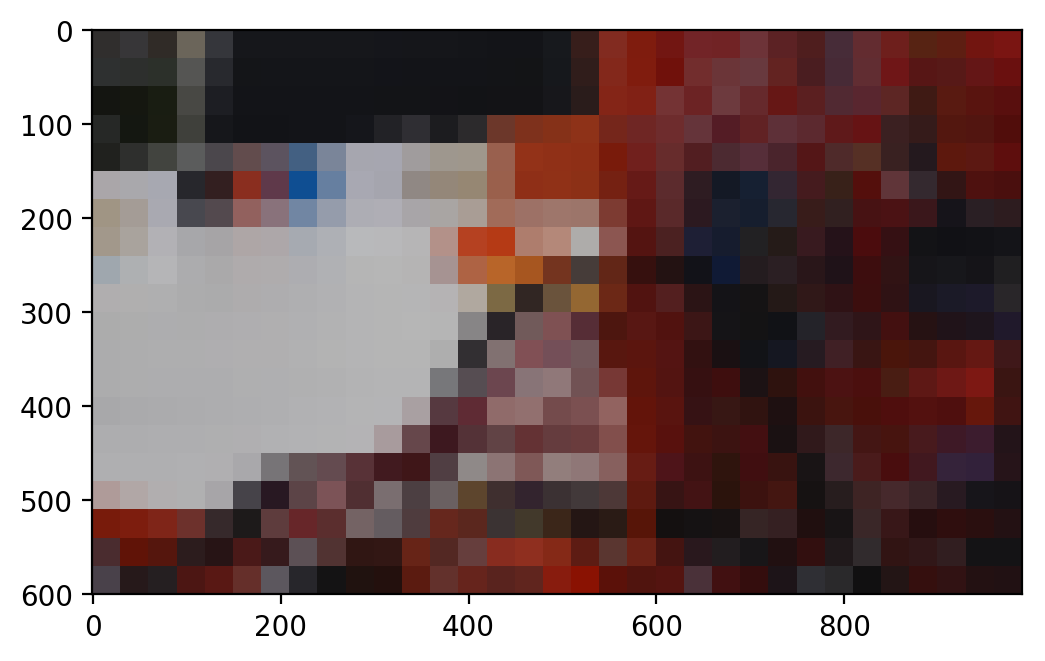

In [300]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.imshow(rough_img)

# Cube sequence searching

In [301]:
def permutations(array, n=None, perm=[]):
    if n == None:
        n = len(array)
    if n == 0:
        yield perm
    else:
        for i in range(len(array)):
            yield from permutations(array[:i] + array[i + 1:], n - 1,
                                    perm + [array[i]])


def all_plans():
    yield from permutations(list(range(5)), 3)


PLANS = list(all_plans())
COLORS = np.array([[0, 124, 176], [208, 93, 40], [14, 14, 16], [97, 153, 59],
          [247, 181, 0]], dtype=np.uint8)
LABELS = ['blue', 'orange', 'black', 'green', 'yellow']

In [302]:
# sv_thr = 120

# hsv_target_colors = cv2.cvtColor(np.array([COLORS]), cv2.COLOR_RGB2HSV)[0]
# hsv_colors = cv2.cvtColor(avg_colors, cv2.COLOR_RGB2HSV)

# dist_array = np.zeros((hsv_colors.shape[0], hsv_colors.shape[1],
#                        hsv_target_colors.shape[0]))
# for i in range(hsv_target_colors.shape[0]):
#     if i == 2:
#         dist_array[:, :, i] = np.where(
#             hsv_colors[:, :, 2] < sv_thr,
#             np.abs(hsv_colors[:, :, 2] - hsv_target_colors[i, 2]), np.inf)
#     else:
#         dist_1 = (hsv_colors[:, :, 0] - hsv_target_colors[i, 0]) % 255
#         dist_2 = (hsv_target_colors[i, 0] - hsv_colors[:, :, 0]) % 255
#         dist_h = np.where(dist_1 < dist_2, dist_1, dist_2)
#         dist_array[:, :, i] = np.where(
#             (hsv_colors[:, :, 2] > 3 * hsv_target_colors[i, 2] / 4) *
#             (hsv_colors[:, :, 1] > 3 * hsv_target_colors[i, 1] / 4), dist_h,
#             np.inf)

# plan_dist_array = np.zeros((hsv_colors.shape[0] - 4, hsv_colors.shape[1],
#                             len(PLANS)))

# for i, plan in enumerate(PLANS):
#     plan_dist_array[:, :, i] = sum([
#         np.roll(dist_array[:, :, plan[x]], -2 * x, axis=0)[:-4, :]
#         for x in range(3)
#     ])

# best_plan = np.unravel_index(
#     np.argmin(plan_dist_array), (hsv_colors.shape[0] - 4, hsv_colors.shape[1],
#                                  len(PLANS)))[2]
# [LABELS[PLANS[best_plan][x]] for x in range(3)]

In [303]:
from colormath.color_diff import delta_e_cie2000, delta_e_cmc 
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color

def color_distance(c1, c2):
    color1 = sRGBColor(*c1, is_upscaled=True)
    lab_color1 = convert_color(color1, LabColor)
    color2 = sRGBColor(*c2, is_upscaled=True)
    lab_color2 = convert_color(color2, LabColor)
    return delta_e_cmc(lab_color1, lab_color2)

In [304]:
# lab_target_colors = np.array(
#     cv2.cvtColor(np.array([COLORS]), cv2.COLOR_RGB2LAB)[0], dtype=np.int32)
# lab_colors = np.array(
#     cv2.cvtColor(avg_colors, cv2.COLOR_RGB2LAB), dtype=np.int32)

# dist_array = np.zeros((lab_colors.shape[0], lab_colors.shape[1],
#                        lab_target_colors.shape[0]))

# for i in range(lab_target_colors.shape[0]):
#     dist_array[:, :, i] = np.sum(
#         (lab_colors - lab_target_colors[i, :]) ** 2, axis=2) **0.5

# plan_dist_array = np.zeros((lab_colors.shape[0] - 4, lab_colors.shape[1],
#                             len(PLANS)))

# for i, plan in enumerate(PLANS):
#     plan_dist_array[:, :, i] = sum([
#         np.roll(dist_array[:, :, plan[x]], -2 * x, axis=0)[:-4, :]
#         for x in range(3)
#     ])

# best_plan = np.unravel_index(
#     np.argmin(plan_dist_array), (lab_colors.shape[0] - 4, lab_colors.shape[1],
#                                  len(PLANS)))[2]
# [LABELS[PLANS[best_plan][x]] for x in range(3)]

In [305]:
dist_array = np.zeros((avg_colors.shape[0], avg_colors.shape[1],
                       COLORS.shape[0]))

for i in range(lab_target_colors.shape[0]):
    dist_array[:, :, i] = np.apply_along_axis(color_distance, 2, avg_colors,
                                              COLORS[i])

plan_dist_array = np.zeros((lab_colors.shape[0] - 4, lab_colors.shape[1],
                            len(PLANS)))

for i, plan in enumerate(PLANS):
    plan_dist_array[:, :, i] = sum([
        np.roll(dist_array[:, :, plan[x]]**2, -2 * x, axis=0)[:-4, :]
        for x in range(3)
    ])

best_plan = np.unravel_index(
    np.argmin(plan_dist_array), (lab_colors.shape[0] - 4, lab_colors.shape[1],
                                 len(PLANS)))[2]
[LABELS[PLANS[best_plan][x]] for x in range(3)]

['black', 'orange', 'blue']

In [306]:
np.unravel_index(
    np.argmin(plan_dist_array), (lab_colors.shape[0] - 4, lab_colors.shape[1],
                                 len(PLANS)))

(3, 5, 27)

In [307]:
plan_dist_array[16, 19]

array([  6527.80243957,  11034.66770608,  11049.32350891,   6853.98518829,
        10427.06206253,  10441.71786537,  11216.5906769 ,  10282.80228463,
        14804.32335397,  10777.62930596,   9843.84091369,  14350.7061802 ,
         5652.44285895,  10159.30812546,  10173.96392829,   5421.95513038,
         5824.54368192,   5839.19948476,   9784.56061898,   5680.28390402,
        10201.80497336,   9345.59924805,   5241.32253309,   9748.18779959,
         7062.9100452 ,  10635.98691944,  10650.64272227,   6506.23956791,
         6908.82811945,   6923.48392228,  10261.23941296,   7090.75109027,
        10678.48376734,   9822.27804203,   6651.78971933,  10224.86659357,
        10512.3377159 ,   9578.54932363,  14100.07039297,   9955.66723861,
         5851.39052364,  10372.91159298,   9348.06159506,   6177.57327236,
         9765.30594943,  13271.70571273,  10101.21739003,   9167.42899776,
         8738.75354833,   7804.96515607,  12311.83042257,   8182.08307104,
         4077.80635608,  

In [308]:
plan_dist_array[15, 19]

array([  4945.88625747,   9698.60823633,   9843.80633794,   6582.74499447,
        10231.77195092,  10376.97005252,  10129.5276187 ,   9025.83259629,
        13923.75267675,   8207.28285765,   7103.58783524,  11856.3098141 ,
         6612.32023211,  11365.04221096,  11510.24031257,   6577.85472322,
         6941.41275384,   7086.61085545,  10124.63734745,   5735.47339921,
        10633.39347968,   8202.3925864 ,   3813.22863817,   8565.95061702,
         7321.62893455,  10970.655891  ,  11115.85399261,   5650.30468867,
         6013.8627193 ,   6159.0608209 ,   9730.25102749,   6444.78210166,
        10239.00715972,   7808.00626644,   4522.53734061,   8171.56429706,
        11161.10375019,  10057.40872778,  14955.32880824,   9489.7795043 ,
         5100.61555607,   9998.53563653,  10022.94321889,   6737.47429306,
        10531.69935112,  11647.48108207,   8362.01215625,   7258.31713384,
        10525.62071937,   9421.92569696,  14174.64767582,   8854.29647349,
         4465.13252525,  

In [309]:
plan_dist_array[2, 18, 30]

10518.689123749522

In [310]:
np.min(plan_dist_array[15, 19])

3813.228638165197

In [311]:
dist_array[19, 19]

array([ 69.6272423 ,  39.52826766,  21.41935857,  72.19079512,  73.18954162])

In [312]:
dist_array[17, 19]

array([ 72.50265232,  17.31592969,  28.86182835,  66.17996494,  49.57361192])

In [313]:
lab_target_colors[1]

array([136, 171, 178])

In [314]:
lab_colors[17, 19]

array([ 85, 166, 159])

In [315]:
lab_colors[19, 19]

array([130, 145, 182])

In [316]:
luv_target_colors = np.array(
    cv2.cvtColor(np.array([COLORS]), cv2.COLOR_RGB2YUV)[0], dtype=np.int32)
luv_colors = np.array(
    cv2.cvtColor(avg_colors, cv2.COLOR_RGB2YUV), dtype=np.int32)

In [317]:
[np.sum((lab_colors[10, 16] - lab_target_colors[i]) ** 2) **0.5 for i in range(5)]

[45.650848842053307,
 73.925638313104884,
 91.093358704133863,
 70.377553239651633,
 125.92458060283545]

In [318]:
[np.sum((lab_colors[7, 5] - lab_target_colors[i]) ** 2) **0.5 for i in range(5)]

[60.621778264910702,
 90.697298746985851,
 66.037867924396224,
 89.810912477270818,
 147.93917669096311]

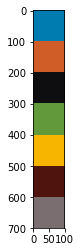

In [319]:
plt.imshow(
    np.concatenate(
        [
            np.tensordot(np.ones((100, 100), dtype=np.uint8), color, axes=0)
            for color in np.concatenate((COLORS,np.array([avg_colors[19, 19]] + [avg_colors[10, 16]])), axis=0)
        ],
        axis=0))

In [320]:
avg_colors[19, 19]

array([80, 20, 14], dtype=uint8)

In [321]:
COLORS

array([[  0, 124, 176],
       [208,  93,  40],
       [ 14,  14,  16],
       [ 97, 153,  59],
       [247, 181,   0]], dtype=uint8)

In [322]:
from colormath.color_diff import delta_e_cie2000, delta_e_cmc 
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color

In [323]:
color1 = sRGBColor(*avg_colors[16, 19], is_upscaled=True)
lab_color1 = convert_color(color1, LabColor)
for i in range(5):
    color2 = sRGBColor(*COLORS[i], is_upscaled=True)
    lab_color2 = convert_color(color2, LabColor)
    print(delta_e_cmc(lab_color1, lab_color2))

70.05993014787788
17.489294774699587
27.974170688251622
65.05368472572643
49.58223198715786


In [324]:
color1

sRGBColor(rgb_r=0.53333333333333333,rgb_g=0.10980392156862745,rgb_b=0.054901960784313725)

In [325]:
avg_colors[5, 5]

array([138,  46,  31], dtype=uint8)

In [326]:
138 / 255

0.5411764705882353